In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from lib.vector import Vector2D

/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ryotafuwa/miniconda3/envs/data-science/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [174]:
## model import
model_filepath = "data/models/2020-10-17.h5" # learned by confidence map labels
model = tf.keras.models.load_model(model_filepath)

## hyper params
THRESHOLD = 0.3

## test_ds import
element_spec = {
    "image": tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
    "label": tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
    }
test_ds = tf.data.experimental.load("data/datasets/test_ds", element_spec)

In [ ]:
for batch in test_ds:
    images = batch['image']
    labels = batch['label']
preds = model.predict(test_ds) > THRESHOLD

In [186]:
# Visualize data

def get_line_idxs(label):
    x, y =  np.where(label.reshape((128, 128)))
    return y, x

def show_point(center, sample_idx=0):
    sample_img, sample_label =  images[sample_idx], labels[sample_idx]
    plt.imshow(sample_img)
    plt.scatter([center[0]], [center[1]], c='red', s=10)
    plt.show()

def show_line(p1, p2, sample_idx=0, label=False):
    sample_img, sample_label = images[sample_idx], labels[sample_idx]
    plt.imshow(sample_img)
    if label:
        x, y = get_line_idxs(sample_label.numpy())
        plt.scatter(x, y, c='blue', s=1)
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-')
    plt.show()

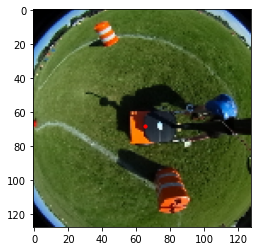

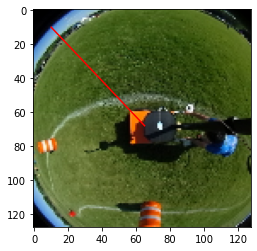

In [210]:
# Define Environment Variables
# Those are set mechanically by observations and measurements.

# get center of the image empirically
center = Vector2D(65, 68)
show_point(center, 0) # (x, y)

# get pixel length from center to the end of camera frame
show_line(Vector2D(10, 10), center, 4)

In [211]:
# environment variables
HEIGHT = 1.8 # height of the camera from the ground.
# CENTER = Vector2D(72, 68) # row, col (determined empirically)
CENTER = center # row, col (determined empirically)
PIXEL_LENGTH = (Vector2D(10, 10) - CENTER).length()  #length(num of pixels) from center to the end of camera

#constants
START_LINE = Vector2D(-1, 0)
RAD_TO_ANGLE = 180 / np.pi
fai_dash = np.pi
theta_ratio = 0.5 * np.pi / 64.0

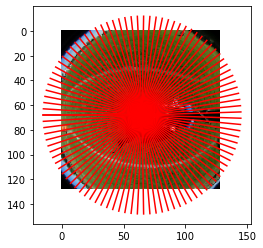

In [221]:
# check those variables are good enough on data
sample_img = images[5]
plt.imshow(sample_img)
for theta in np.linspace(-np.pi, np.pi, 100):
    vec = Vector2D(np.cos(theta), np.sin(theta)).unit() * PIXEL_LENGTH + CENTER
    plt.plot([vec[0], CENTER[0]], [vec[1], CENTER[1]], 'r-')
plt.show()



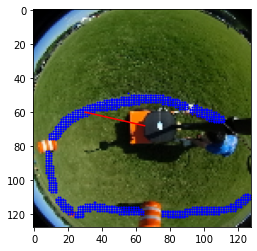

In [213]:
# experiment2
# vec = (Vector2D(-1, -1).unit() * 21).floor() + CENTER
vec = Vector2D(30, 60)
# vec = Vector2D(10, 68)
show_line(vec, CENTER, 4, True)


In [222]:
def r_fai(vec):
    diff = vec - CENTER
    fai = diff.arg(START_LINE)

    theta = diff.length() * (np.pi / 2) / PIXEL_LENGTH # make sure 0 <= theta < np.pi / 2
    if theta >= np.pi / 2:
        return float('inf'), fai
    return HEIGHT * np.tan(theta), fai


In [223]:
# experiment3
# vec = (Vector2D(-1, -1).unit() * 21).floor() + CENTER
# vec = Vector2D(30, 60)
# vec = Vector2D(10, 10)
vec = Vector2D(100, 71)

r, fai = r_fai(vec)
print(r, int(fai * RAD_TO_ANGLE))

1.4866244122563614 -175


In [224]:
def get_idx_from_fai(fai):
    fai = fai * RAD_TO_ANGLE
    if fai < -180 or fai >= 180:
        return -1
    decimal, i = np.modf(fai)
    idx = int(i * 2 + (1 if decimal >= 0.5 else 0))
    return idx + 360

In [225]:
def confidence_map2scan(confidence_map, threshold_for_p=0.3, threshold_for_distance=3.0):
    scan = [float('inf') for _ in range(720)]
    segment = confidence_map > threshold_for_p
    xs, ys = get_line_idxs(segment)
    for x, y in zip(xs, ys):
        vec = Vector2D(x, y)
        r, fai = r_fai(vec)
        idx = get_idx_from_fai(fai)
        if 0 <= idx < len(scan):
            scan[idx] = min(scan[idx], r)

    for idx, distance in enumerate(scan):
        if distance > threshold_for_distance:
            scan[idx] = 0
    return scan

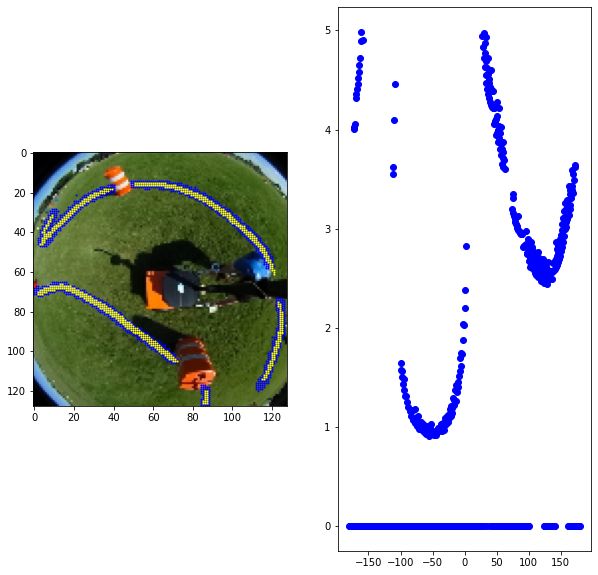

In [232]:
image = images[0]
label = labels[0].numpy().reshape((128, 128))
pred = preds[0].reshape((128, 128))
scan = confidence_map2scan(pred, threshold_for_distance=5.0)
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].scatter(*get_line_idxs(label), c='blue', s=1)
ax[0].scatter(*get_line_idxs(pred), c='yellow', s=1)
ax[1].plot(np.arange(-180, 180, .5),  scan, 'bo')
plt.show()